<a href="https://colab.research.google.com/github/beatrizrgarcia/solowmodel/blob/main/solowmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn
!pip install matplotlib
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
import seaborn as sns

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Instalação e importação de pacotes importantes para a realização do modelo

In [ ]:
pwt = pd.read_excel("pwt.xlsx")

In [ ]:
delta = 0.05
first_year = 1960
last_year = 2019

oil_countries =  ['Bahrain', 'Gabon', 'Iran (Islamic Republic of)', 'Iraq', 'Kuwait', 'Oman', 'Saudi Arabia', 'United Arab Emirates', 'Lesotho']
notoils = pwt.loc[~pwt["country"].isin(oil_countries)]

first_year_data = notoils[notoils["year"] == first_year].dropna(subset=["rgdpo", "emp"])
countries_in_first_year = first_year_data["country"].unique()

pwt_solow = notoils[['year', 'country', 'rgdpo', 'pop', 'emp', 'csh_i', 'hc']]
pwt_solow = pwt_solow[
    (pwt_solow["year"] <= last_year)
    & (pwt_solow["country"].isin(countries_in_first_year))
]
print(pwt_solow)

       year    country         rgdpo        pop       emp     csh_i        hc
350    1950  Argentina  50108.761719  17.091824  6.608833  0.084720  1.816503
351    1951  Argentina  51339.167969  17.457578  6.713252  0.125594  1.830769
352    1952  Argentina  46855.101562  17.815967  6.819321  0.118653  1.845147
353    1953  Argentina  49917.148438  18.168618  6.927065  0.118317  1.859638
354    1954  Argentina  52254.769531  18.517168  7.036511  0.108073  1.874243
...     ...        ...           ...        ...       ...       ...       ...
12805  2015   Zimbabwe  39798.644531  13.814629  6.393752  0.077963  2.584653
12806  2016   Zimbabwe  40963.191406  14.030331  6.504374  0.076169  2.616257
12807  2017   Zimbabwe  44316.742188  14.236595  6.611773  0.075448  2.648248
12808  2018   Zimbabwe  43420.898438  14.438802  6.714952  0.079576  2.680630
12809  2019   Zimbabwe  40826.570312  14.645468  6.831017  0.077089  2.713408

[6230 rows x 7 columns]


- Importação da base mais atualizada da PWT
- Consideração de g_delta como 0.05 (igual ao trabalho do Nicholas) - nomeei g_delta no código como delta
- Retirada dos países petrolíferos da base da PWT (motivo: podem distorcer os resultados) e decisão de considerar dados da PWT apenas a partir de 1970
- Criação de um novo df a partir da base da PWT sem os países petrolíferos que considera apenas as colunas: 'year', 'country', 'rgdpo' (Produto Interno Bruto real no lado da produção a preços de paridade do poder de compra encadeados - em milhões de dólares em 2019), 'pop'(população em milhões), 'emp' (nº de pessoas empregadas em milhões), 'hc'(Índice de capital humano), 'csh_i' ( parcela da formação bruta de capital físico)
- Retirada de valores nulos do novo df (motivo: várias funções e pacotes do Python não funcionam com valores NaN - Nicholas retirou também)


In [ ]:
pwt_solow['n'] = pwt_solow.groupby('country')['emp'].pct_change().mean(skipna=True)
pwt_solow['gdp_pw'] = pwt_solow['rgdpo'] / pwt_solow['emp']
pwt_solow['log_gdp_pw'] = np.log(pwt_solow['gdp_pw'])
pwt_solow['investment'] = pwt_solow.groupby('country')['csh_i'].transform("mean")
pwt_solow['restricted1'] = np.log(pwt_solow['investment']) - np.log(pwt_solow['n'] + delta)
pwt_solow = pwt_solow.reset_index(drop=True)
print(pwt_solow)

      year    country         rgdpo        pop       emp     csh_i        hc  \
0     1950  Argentina  50108.761719  17.091824  6.608833  0.084720  1.816503   
1     1951  Argentina  51339.167969  17.457578  6.713252  0.125594  1.830769   
2     1952  Argentina  46855.101562  17.815967  6.819321  0.118653  1.845147   
3     1953  Argentina  49917.148438  18.168618  6.927065  0.118317  1.859638   
4     1954  Argentina  52254.769531  18.517168  7.036511  0.108073  1.874243   
...    ...        ...           ...        ...       ...       ...       ...   
6225  2015   Zimbabwe  39798.644531  13.814629  6.393752  0.077963  2.584653   
6226  2016   Zimbabwe  40963.191406  14.030331  6.504374  0.076169  2.616257   
6227  2017   Zimbabwe  44316.742188  14.236595  6.611773  0.075448  2.648248   
6228  2018   Zimbabwe  43420.898438  14.438802  6.714952  0.079576  2.680630   
6229  2019   Zimbabwe  40826.570312  14.645468  6.831017  0.077089  2.713408   

             n       gdp_pw  log_gdp_pw

- Criação da variável 'n' no df onde a função pct_change calcula a variação percentual de 'emp' e a função mean calcula a média das variações percentuais calculadas no passo anterior. Portanto, 'n' resulta na  taxa de crescimento populacional
- Criação da cvariável 'gdp_pw' no df que será caracterizada pela divisão dos valores de 'rgdpo' por 'emp' para cada país. Assim, 'gdp_pw" será o PIB por trabalhador
- Criação da variável 'log_gdp_pw' no df que será o log de 'gdp_pw'
- Criação da variável 'investment' que calcula, para cada país, a média dos valores da variável 'csh_i'. Sendo, portanto, a taxa de investimento/poupança de cada país
- Criação da variável 'restricted1' que calcula a expressão:
 log * 'investment' - log * ('n' + delta)



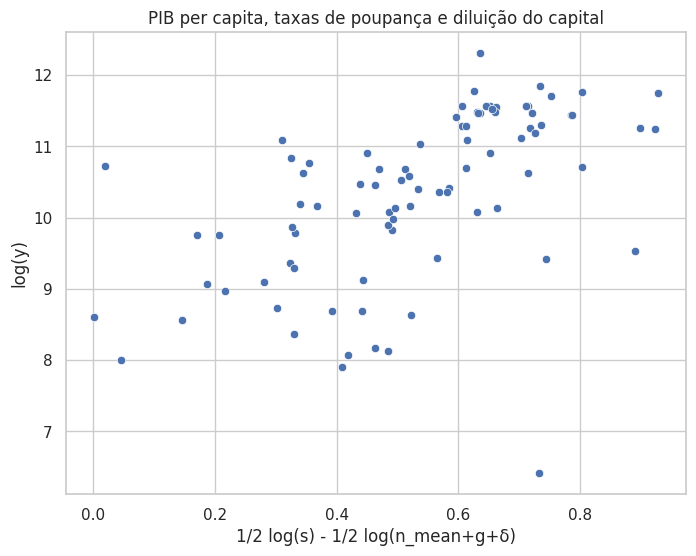

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pwt_solow[pwt_solow["year"] == last_year], x=0.5 * np.log(pwt_solow['investment']) - 0.5 * np.log(pwt_solow['n'] + delta), y='log_gdp_pw')
plt.title ('PIB per capita, taxas de poupança e diluição do capital')
plt.xlabel('1/2 log(s) - 1/2 log(n_mean+g+δ)')
plt.ylabel('log(y)')
plt.show()
# colocar valor nos pontinhos

- Criação do gráfico sendo:
eixo x: 0.5 * log (investment) - 0.5 * log (n + delta)
eixo y: log_gdp_pw

                         Non-oil        Intermediate               OECD
                                                                       
ln(s)          1.608***  (0.260)   1.623***  (0.260)   0.846**  (0.260)
ln(n+g+δ)     -4.254***  (0.141)  -4.259***  (0.141)    -4.140  (0.141)
Constant          1.600  (0.053)      1.602  (0.053)  1.558***  (0.053)
Observations                  89                  84                 28
Adjusted R2                0.297               0.274              0.160
                            OLS Regression Results                            
Dep. Variable:             log_gdp_pw   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     38.14
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           2.05e-08
Time:                        14:34:14   Log-Likelihood:                -124.05
No. Observations:     

<Axes: xlabel='investment'>

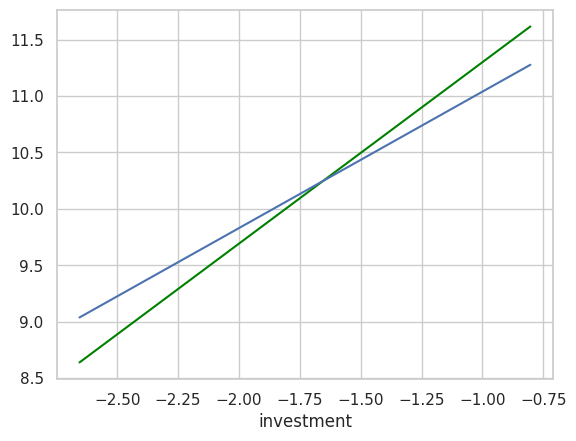

In [ ]:
pwt_solow19 = pwt_solow[pwt_solow['year'] == last_year]
modelo = 'log_gdp_pw ~ np.log(investment) + np.log(n + delta)'
OECD_countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Republic of Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
OECD = pwt_solow19.loc[pwt["country"].isin(OECD_countries)]

reg1_1 = sm.OLS.from_formula(modelo, data=pwt_solow19).fit()
reg1_2 = sm.OLS.from_formula(modelo, data=pwt_solow19[pwt_solow19['pop'] > 1]).fit()
reg1_3 = sm.OLS.from_formula(modelo, data=pwt_solow19[pwt_solow19['country'].isin(OECD_countries)]).fit()

summary_table = pd.DataFrame()
summary_table[''] = ['ln(s)', 'ln(n+g+δ)', 'Constant', 'Observations', 'Adjusted R2']
summary_table.set_index('', inplace=True)

summary_table['Non-oil'] = [f'{reg1_1.params["np.log(investment)"]:.3f}***', f'{reg1_1.params["np.log(n + delta)"]:.3f}***', f'{reg1_1.params["Intercept"]:.3f}', f'{int(reg1_1.nobs)}', f'{reg1_1.rsquared_adj:.3f}']
summary_table['Intermediate'] = [f'{reg1_2.params["np.log(investment)"]:.3f}***', f'{reg1_2.params["np.log(n + delta)"]:.3f}***', f'{reg1_2.params["Intercept"]:.3f}', f'{int(reg1_2.nobs)}', f'{reg1_2.rsquared_adj:.3f}']
summary_table['OECD'] = [f'{reg1_3.params["np.log(investment)"]:.3f}**', f'{reg1_3.params["np.log(n + delta)"]:.3f}', f'{reg1_3.params["Intercept"]:.3f}***', f'{int(reg1_3.nobs)}', f'{reg1_3.rsquared_adj:.3f}']

# Adicione os erros-padrão entre parênteses
summary_table.loc['ln(s)'] = summary_table.loc['ln(s)'] + f'  ({reg1_1.bse["np.log(investment)"]:.3f})'
summary_table.loc['ln(n+g+δ)'] = summary_table.loc['ln(n+g+δ)'] + f'  ({reg1_1.bse["np.log(n + delta)"]:.3f})'
summary_table.loc['Constant'] = summary_table.loc['Constant'] + f'  ({reg1_1.bse["Intercept"]:.3f})'

print (summary_table)

p1 = reg1_1.params["np.log(investment)"]
p2 = reg1_1.params["np.log(n + delta)"]
p3 = reg1_1.params["Intercept"]

p11 = 1.209
p22 = -3.655
p33 = 2.533

print(reg1_1.summary())
print(reg1_2.summary())
print(reg1_3.summary())




sns.lineplot(data=pwt_solow19, x = np.log(pwt_solow19['investment']), y = p1*np.log(pwt_solow19['investment']) + p2*np.log(pwt_solow19["n"] + delta) + p3, color='green')
sns.lineplot(data=pwt_solow19, x = np.log(pwt_solow19['investment']), y = p11*np.log(pwt_solow19['investment']) + p22*np.log(pwt_solow19["n"] + delta) + p33)

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

# creating the plot
#ax.scatter(np.log(pwt_solow19['investment']), np.log(pwt_solow19["n"] + delta), pwt_solow19['log_gdp_pw'], color='green')

- Em primeiro lugar, é realizado uma variável nomeada 'modelo' que será a formulá utilizada para a regressão linear múltipla (OLS) tendo a variável log_gdp_pw como variável dependente e [log (investment)] e [log (n+ delta)] como variavéis independentes.
- Definição dos países da OCDE e criação de uma variável nomeada 'OCDE' que seleciona, diretamente, da variável pwt_solow os países pertencentes ao grupo
- Uso da biblioteca Statsmodels para criação de um modelo de regressão linear com base em uma fórmula especificada em 'modelo' e usando o DataFrame pwt_solow19 (base da pwt_solow que contenha apenas os dados de 2019) como os dados de entrada para o modelo - países oils são excluídos.
- Uso da biblioteca Statsmodels para criação de um modelo de regressão linear com base em uma fórmula especificada em 'modelo' e usando o DataFrame pwt_solow19 (base da pwt_solow que contenha apenas os dados de 2019) como os dados de entrada para o modelo - países oils são excluídos. Nesse caso, há uma condição: apenas os países que contenham mais de 1 de população entrarão na regressão
- Uso da biblioteca Statsmodels para criação de um modelo de regressão linear com base em uma fórmula especificada em 'modelo' e usando o DataFrame pwt_solow19 (base da pwt_solow que contenha apenas os dados de 2019) como os dados de entrada para o modelo - países oils são excluídos. Nesse caso, há uma condição: apenas os países membros da OCDE entrarão na regressão
- Criação de três colunas em uma tabela chamada 'summary_table', onde cada coluna contém informações resumidas de três modelos de regressão - sendo a primeira coluna "Non-Oils" contendo informações da primeira regressão, a segunda coluna "Intermediate" contendo informações da segunda regressão e "OCDE" contendo informações da terceira regressão.
- As informações contidadas na tabela, para cada coluna e calculada para cada regressão, serão: o coeficiente estimado para a variável "np.log(investment)" com formatação em 3 casas decimais e com três asteriscos no final (os asteriscos podem indicar que o coeficiente é estatisticamente significativo), segundo valor é o coeficiente estimado para a variável "np.log(n + delta)" no modelo, também com formatação em 3 casas decimais e três asteriscos, o terceiro valor é o coeficiente estimado para a constante (Intercept) no modelo com formatação em 3 casas decimais, o quarto valor é o número de observações no modelo, convertido em inteiro com int e o quinto valor é o valor do coeficiente de determinação ajustado (R² ajustado) para o modelo com formatação em 3 casas decimais.
- como os resultados não foram iguais ao encontrado pelo Nicolas, fiz um gráfico que mostrasse a diferença de nossas regressões - sendo a linha verde em relação aos meus resultados encontrados e a linha azul em relação aos resultados do Nicolas.
- ver o método de regressão - painel e quais efeitos usou

                             Non-oil       Intermediate                OECD
                                                                           
ln(s) - ln(n+g+δ)  1.608***  (0.260)  1.623***  (0.260)   0.846***  (0.260)
Constant           8.635***  (0.295)  8.609***  (0.295)  10.314***  (0.295)
Implied Alpha                                                              
Observations                      89                 84                  28
Adjusted R2                    0.297              0.274               0.160
                            OLS Regression Results                            
Dep. Variable:             log_gdp_pw   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     38.14
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           2.05e-08
Time:                        14:34:15   Log-Likelihood:                -1

<Axes: xlabel='restricted1', ylabel='restricted1'>

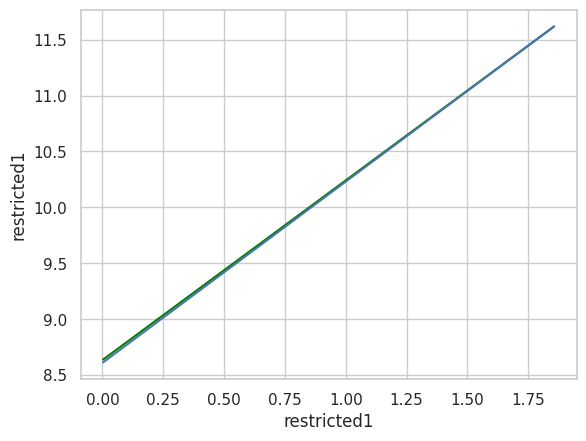

In [ ]:
model2 = 'log_gdp_pw ~ restricted1'


reg2_1 = sm.OLS.from_formula(model2, data=pwt_solow19).fit()
reg2_2 = sm.OLS.from_formula(model2, data=pwt_solow19[pwt_solow19['pop'] > 1]).fit()
reg2_3 = sm.OLS.from_formula(model2, data=pwt_solow19[pwt_solow19['country'].isin(OECD_countries)]).fit()

summary_table2 = pd.DataFrame()
summary_table2[''] = ['ln(s) - ln(n+g+δ)', 'Constant', 'Implied Alpha', 'Observations', 'Adjusted R2']
summary_table2.set_index('', inplace=True)

summary_table2['Non-oil'] = [f'{reg2_1.params["restricted1"]:.3f}***', f'{reg2_1.params["Intercept"]:.3f}***', '', f'{int(reg2_1.nobs)}', f'{reg2_1.rsquared_adj:.3f}']
summary_table2['Intermediate'] = [f'{reg2_2.params["restricted1"]:.3f}***', f'{reg2_2.params["Intercept"]:.3f}***', '', f'{int(reg2_2.nobs)}', f'{reg2_2.rsquared_adj:.3f}']
summary_table2['OECD'] = [f'{reg2_3.params["restricted1"]:.3f}***', f'{reg2_3.params["Intercept"]:.3f}***', '', f'{int(reg2_3.nobs)}', f'{reg2_3.rsquared_adj:.3f}']

summary_table2.loc['ln(s) - ln(n+g+δ)'] = summary_table2.loc['ln(s) - ln(n+g+δ)'] + f'  ({reg2_1.bse["restricted1"]:.3f})'
summary_table2.loc['Constant'] = summary_table2.loc['Constant'] + f'  ({reg2_1.bse["Intercept"]:.3f})'

print(summary_table2)

print(reg2_1.summary())
print(reg2_2.summary())
print(reg2_3.summary())

p1 = reg2_1.params["restricted1"]
p3 = reg2_1.params["Intercept"]

p11 = 1.622
p33 = 8.609

sns.lineplot(data=pwt_solow19, x = (pwt_solow19['restricted1']), y = p1*(pwt_solow19['restricted1']) + p3, color='green')
sns.lineplot(data=pwt_solow19, x = (pwt_solow19['restricted1']), y = p11*(pwt_solow19['restricted1']) + p33)


- Criação do model2 que será 'log_gdp_pw ~ restricted1'.
As três regressões lineares são ajustados usando o método de Mínimos Quadrados Ordinários (OLS), sendo que:
reg2_1 é a regressão para todo o conjunto de dados - PWT menos países petroleiros
reg2_2 é a regressão para o subconjunto onde 'pop' é maior que 1.
reg2_3 é a regressão para os países na lista especificada (OECD_countries)
- Uma tabela vazia (summary_table2) é criada para armazenar os resultados das regressões. Os rótulos das linhas são definidos como ['ln(s) - ln(n+g+δ)', 'Constant', 'Implied_Alpha', 'Observações', 'R2 Ajustado']- não consegui calcular o Implied_Alpha porque não entendi como ele foi criado no código em R
- Os coeficientes estimados, estatísticas e outras informações das regressões são inseridos na tabela summary_table2.
-A tabela summary_table2 é impressa na tela, fornecendo uma visão resumida dos resultados das regressões.
-As estatísticas detalhadas dos modelos de regressão são impressas, incluindo coeficientes, erros-padrão, valores p, R-quadrado ajustado, etc.
- Como os resultados não foram iguais ao encontrado pelo Nicolas, fiz um gráfico que mostrasse a diferença de nossas regressões - sendo a linha verde em relação aos meus resultados encontrados e a linha azul em relação aos resultados do Nicolas.

Próximos passos:
2 - Reler os artigos - relacionando com o modelo e com uma leitura um pouco mais "ativa"- e pensar mais na interpretação do modelo
1 - Conversar com o Nicolas sobre como ele fez o código - entender melhor as funções do R que ele utilizou, perguntar sobre o Implied_Alpha.
2 - Terminar de fazer o modelo - Modelo de Solow Aumentado e Convergência
3 - Incluir uma lista de outro grupo de países nas regressões (BRICS?)
Próximos dias - prioridade:
1 - Documentação do statsmodels sobre o método de estimação (painel e efeitos fixos), países da OCDE
2 - calcular o Implied_Alpha obtido pela estimação (próximo de 1/3) -> isso pode estar causando as diferenças
3 - Corrigir os erros antes de tentar o solow aumentado
